In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer import MCMC, HMC, NUTS
from tqdm.auto import trange

In [ ]:
import GPy

# Generate noisy observations from sinusoidal function

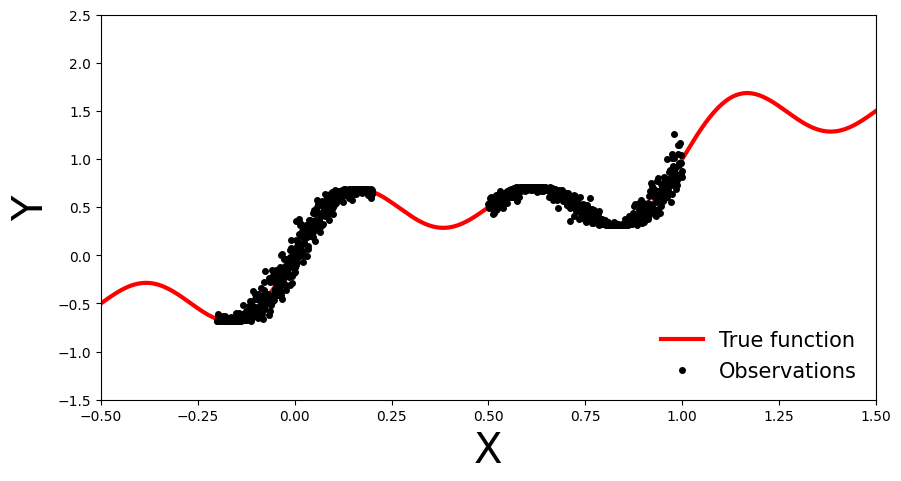

In [89]:
# Observed noisy data
x_obs = np.hstack([np.linspace(0.5, 1, 500), np.linspace(-0.2, 0.2, 500)])
n = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + n)) + 0.3 * np.sin(4 * np.pi * (x_obs + n)) + n

# True noise free function
x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Test data
x_test = torch.linspace(-0.5, 1.5, 3000)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'r-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

(array([61., 16., 16., 14.,  9.,  7.,  6.,  5.,  5.,  3.,  5.,  7.,  4.,
         6.,  3.,  2.,  5.,  7.,  6.,  3.,  3.,  5.,  2.,  1.,  5.,  2.,
         3.,  3.,  4.,  3.,  7.,  4.,  4.,  5.,  4.,  2.,  4.,  1.,  4.,
         3.,  1.,  3.,  2.,  3.,  7.,  3.,  3.,  2.,  4.,  5.,  3.,  1.,
         2.,  7.,  2., 31., 34., 28., 21., 16., 25., 12., 16., 18., 19.,
        20., 18., 25., 17., 17., 19., 26., 23., 37., 37., 50., 77., 62.,
         2.,  6.,  5.,  4.,  2.,  3.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,
         1.,  1.,  1.,  1.,  0.,  2.,  2.,  1.,  3.]),
 array([-0.68630667, -0.66835209, -0.65039751, -0.63244293, -0.61448834,
        -0.59653376, -0.57857918, -0.5606246 , -0.54267002, -0.52471544,
        -0.50676085, -0.48880627, -0.47085169, -0.45289711, -0.43494253,
        -0.41698795, -0.39903336, -0.38107878, -0.3631242 , -0.34516962,
        -0.32721504, -0.30926046, -0.29130587, -0.27335129, -0.25539671,
        -0.23744213, -0.21948755, -0.20153297, -0.18357838, -0.165623

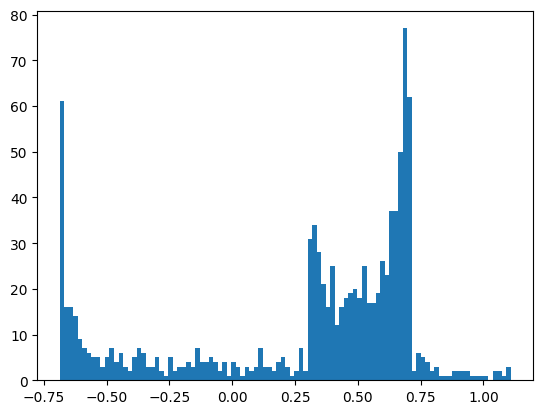

In [3]:
plt.hist(y_obs, bins=100)

Utility function to plot predictions, prediction mean, true function and the observed data

In [4]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    # ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

# BNN with Gaussian prior and likelihood

In [6]:
class Model(PyroModule):
    def __init__(self,h1, h2, prior_sigma):
        super().__init__()
        '''
        Define the model for the BNN
        param h1: number of neurons in the first hidden layer
        param h2: number of neurons in the second hidden layer
        param prior_sigma: standard deviation of the prior distribution of the weights and biases
        '''
        self.fc1 = PyroModule[nn.Linear](1, h1) # input to hidden layer
        self.fc2 = PyroModule[nn.Linear](h1, h2) # hidden layer 1 to hidden layer 2
        self.fc3 = PyroModule[nn.Linear](h2, 1) # hidden layer 2 to output layer

        # set priors for all weights and biases
        self.fc1.weight = PyroSample(dist.Normal(0., prior_sigma).expand([h1, 1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., prior_sigma).expand([h1]).to_event(1))
        
        self.fc2.weight = PyroSample(dist.Normal(0., prior_sigma).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., prior_sigma).expand([h2]).to_event(1))
        
        self.fc3.weight = PyroSample(dist.Normal(0., prior_sigma).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., prior_sigma).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze() # output of the neural network: mu = neural_net_theta(x_i)
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.)) # prior on \sigma (std dev of posterior of y; y|x, $\theta$) of p(y_i | x_i, \theta) = N( neural_net_theta(x_i), \sigma^2 )
        
        # sample y (observed) from the normal distribution with mean mu (neural_net_theta(x_i)) and std dev \sigma
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y) # y_i ~ N( neural_net_theta(x_i), \sigma^2 )
        return mu

prior of the \sigma: dictated by the problem!
network must be strictly convex in some cases
typically use normal distribution prior: play around with the prior 
\sigma: influence of prior (gamma and lognormla and uniform)

In [8]:
pyro.clear_param_store()

## 1.Training BNN (SVI)

In [23]:
model = Model(20,20,1.)
guide = AutoDiagonalNormal(model) # This implementation of AutoContinuous uses a Normal distribution with a diagonal covariance matrix to construct a guide over the entire latent space. This is because of the mean-field VI assumption
# The guide does not depend on the model’s
# adam = pyro.optim.Adam({"lr": 1e-3}, {"clip_norm": 100.})
adam = pyro.optim.Adam({"lr": 0.001, "betas": (0.999, 0.999)}, {"clip_norm": 2.})
# pyro.optim.Adam()
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()

num_epochs = 25000
bar = trange(num_epochs)
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()
loss_svi = []
for epoch in bar:
    elbo_loss = svi.step(x_train, y_train)
    bar.set_postfix(loss=f'{elbo_loss / x_obs.shape[0]:.3f}')
    loss_svi.append(elbo_loss)
    if epoch % 1000 == 0:
        logging.info("Elbo loss: {}".format(elbo_loss))
        print("Elbo loss: {}".format(elbo_loss))
        

  0%|          | 0/25000 [00:00<?, ?it/s]

Elbo loss: 4990.442985653877
Elbo loss: 1123.653981089592
Elbo loss: 1240.5759227275848
Elbo loss: 945.5774906277657
Elbo loss: -137.5119373202324
Elbo loss: -244.71727240085602
Elbo loss: -261.5507645010948
Elbo loss: -218.47509676218033
Elbo loss: -309.2033520936966
Elbo loss: -333.6280195713043
Elbo loss: -370.50675970315933
Elbo loss: -345.0105627775192
Elbo loss: -262.72408026456833
Elbo loss: -373.69888734817505
Elbo loss: -424.50547766685486
Elbo loss: -261.58591240644455
Elbo loss: -425.9056247472763
Elbo loss: -437.664081633091
Elbo loss: -429.98125183582306
Elbo loss: -429.68795144557953
Elbo loss: -306.91762256622314
Elbo loss: -373.73281812667847
Elbo loss: -429.6245778799057
Elbo loss: -455.4520588517189
Elbo loss: -431.00230145454407


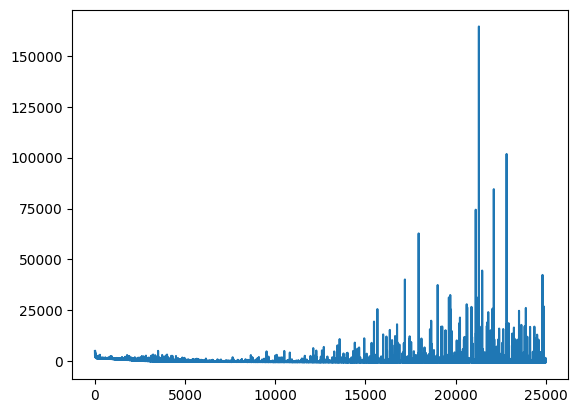

In [24]:
plt.plot(loss_svi)

Compute the predictive distribution sampling from the trained variational density

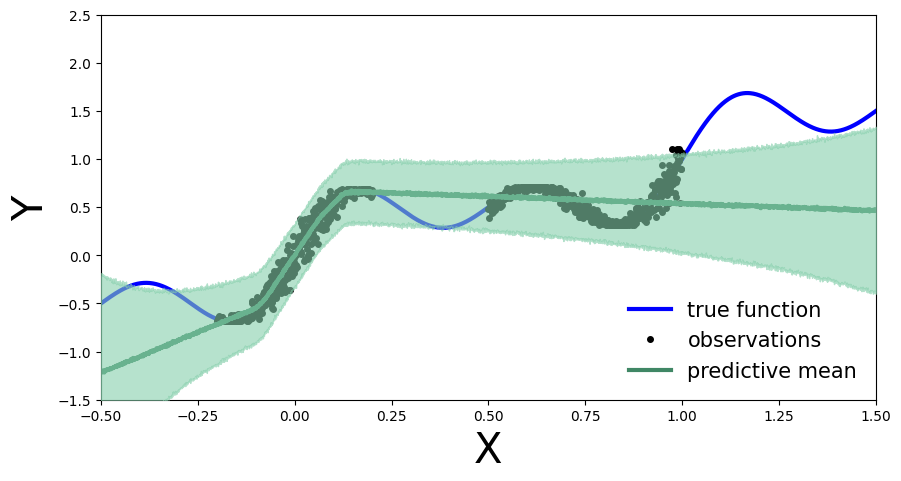

In [25]:
predictive_svi = Predictive(model, guide=guide, num_samples=500)
preds_svi = predictive_svi(x_test)
plot_predictions(preds_svi)

just reshaping and stuff for the samples of each param and creating a dict, svi_samples

In [26]:
svi_samples = {}
for k, v in predictive_svi(x_test).items():
    if k != "obs":
        print(k, v.shape)
        svi_samples[k] = v.detach().cpu().numpy()

fc1.weight torch.Size([500, 1, 20, 1])
fc1.bias torch.Size([500, 1, 20])
fc2.weight torch.Size([500, 1, 20, 20])
fc2.bias torch.Size([500, 1, 20])
fc3.weight torch.Size([500, 1, 1, 20])
fc3.bias torch.Size([500, 1, 1])
sigma torch.Size([500, 1])


Table of means and standard deivations of weight and bias of each neuron in the 1st hidden layer

In [29]:
layer1  = pd.DataFrame( {'fc1.weight-mean': list(torch.mean(torch.Tensor(svi_samples['fc1.weight']), dim=0)[0].numpy().flatten()),
 'fc1.weight- std': list(torch.std(torch.Tensor(svi_samples['fc1.weight']), dim=0)[0].numpy().flatten()),
  'fc1.bias-mean': list(torch.mean(torch.Tensor(svi_samples['fc1.bias']), dim=0).numpy().flatten()),
   'fc2.bias-std': list(torch.std(torch.Tensor(svi_samples['fc1.bias']), dim=0)[0].numpy().flatten())}
)
layer1

,fc1.weight-mean,fc1.weight- std,fc1.bias-mean,fc2.bias-std
0,-0.829854,0.799712,-1.514703,0.560294
1,-0.465254,0.458180,-0.647727,0.260225
2,-0.761623,0.771858,-1.396604,0.538531
3,-0.714349,0.799186,-1.596251,0.622151
4,-1.057754,0.095665,0.064661,0.006227
5,-0.874105,0.745691,-1.378361,0.555964
6,-0.531903,0.502305,-0.743302,0.273270
7,-0.298160,0.429458,-0.703995,0.297263
8,-1.391562,0.054142,0.176782,0.003665
9,-0.707482,0.804399,-1.383672,0.518293


Means of bias of each neuron in the 2nd hidden layer

In [27]:
torch.mean(torch.Tensor(svi_samples['fc2.bias']), dim=0)

tensor([[-1.6665,  1.0370, -1.7540, -1.5506, -1.7267, -1.6852, -1.6210, -1.7358,
         -0.7219,  0.2379, -1.6762, -1.5124, -1.7669, -1.6316, -1.2646, -1.3294,
         -1.6753, -1.8902,  0.4069, -1.6720]])

Std deviations of weights of each neuron in the 2nd hidden layer

In [36]:
torch.std(torch.Tensor(svi_samples['fc2.bias']), dim=0)

tensor([[0.6554, 0.0088, 0.7184, 0.6475, 0.6745, 0.6508, 0.6938, 0.7059, 0.3457,
         0.0251, 0.7133, 0.6559, 0.6591, 0.6654, 0.5006, 0.5298, 0.6608, 0.6994,
         0.0123, 0.6709]])

Means of weights of each neuron in the 2nd hidden layer

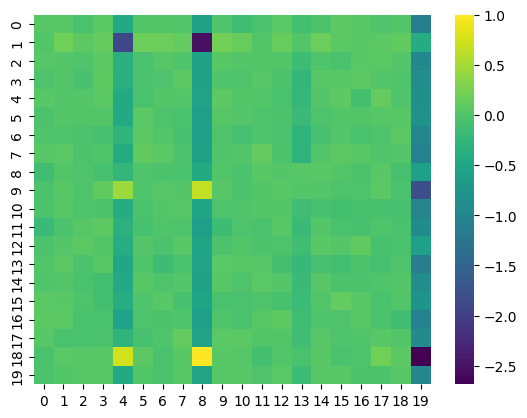

In [37]:
m = torch.mean(torch.Tensor(svi_samples['fc2.weight']), dim=0)
m_np = m.numpy().flatten().reshape(20,20)
sns.heatmap(m_np, cmap='viridis')

plt.show()

Std deviations of weights of each neuron in the 2nd hidden layer

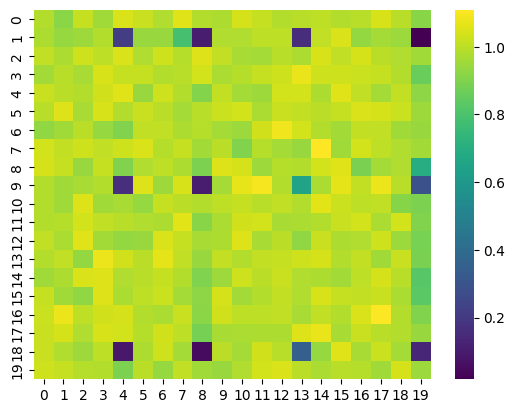

In [34]:
std_devs = torch.std(torch.Tensor(svi_samples['fc2.weight']), dim=0)
std_devs_np = std_devs.numpy().flatten().reshape(20,20)
sns.heatmap(std_devs_np, cmap='viridis')

plt.show()

## 2. Training BNN (HMC)

In [107]:

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
hmc_kernel = HMC(model, 
                #  num_steps=1000,
                 step_size=0.0001,
 trajectory_length=5, 
#  adapt_step_size=True,
#  adapt_mass_matrix=True,
   full_mass=False,
    jit_compile=True)

# Define MCMC sampler, get 'num_samples' posterior samples with burin in 'warmup_steps'
mcmc = MCMC(hmc_kernel, num_samples=50, warmup_steps=50)

# Run MCMC sampler
mcmc.run(x_train, y_train)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Warmup:   0%|          | 0/100 [00:00, ?it/s]/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.11/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 100/100 [43:21, 26.01s/it, step size=8.99e-05, acc. prob=0.703]


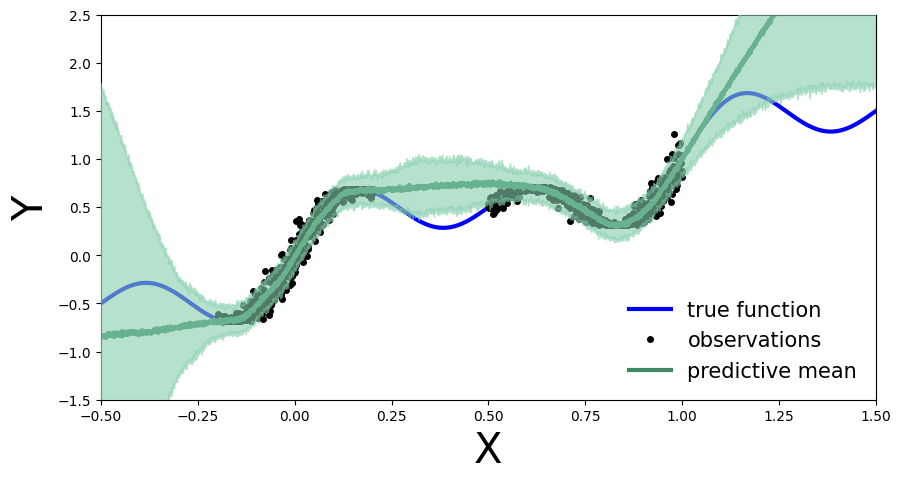

In [108]:
predictive_hmc = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds_hmc = predictive_hmc(x_test.flatten())
plot_predictions(preds_hmc)

## 3. Training BNN (NUTS)

In [40]:
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (NUTS) kernel
nuts_kernel = NUTS(model, jit_compile=False)

# Define MCMC sampler, get 'num_samples' posterior samples with burin in 'warmup_steps'
mcmc_nuts = MCMC(nuts_kernel, num_samples=500, warmup_steps=50)

# Run MCMC sampler
mcmc_nuts.run(x_train, y_train)

nuts_samples = {k: v.detach().cpu().numpy() for k, v in mcmc_nuts.get_samples().items()}

Sample: 100%|██████████| 550/550 [08:44,  1.05it/s, step size=9.16e-04, acc. prob=0.913]


Calculating and plotting the predictive distribution

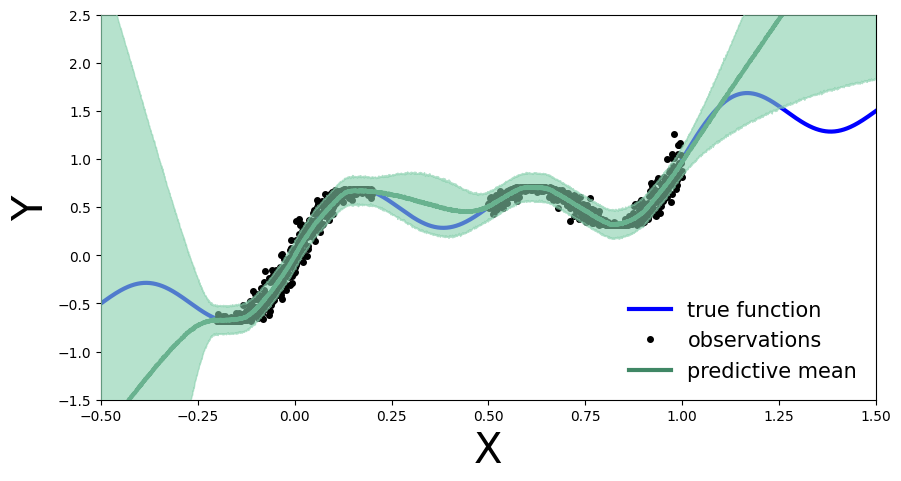

In [91]:
predictive_nuts = Predictive(model=model, posterior_samples=mcmc_nuts.get_samples())
preds_nuts = predictive_nuts(x_test)
plot_predictions(preds_nuts)

Iterate over each site in the `hmc_samples` dictionary and print the site name and its corresponding values.

In [ ]:
# for site, values in summary(nuts_samples).items():
#     print("Site: {}".format(site))
#     print(values, "\n")

### Comparing Posterior Distributions¶

### plot of posteriors of samples of SVI and NUTS of weights of layer 1

/var/folders/f6/9mr1g0xj6mqf2jl8_cvr2lwc0000gn/T/ipykernel_11651/4163580306.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neuron_weights_svi, ax=axs[i], label="SVI (DiagNormal)")
/var/folders/f6/9mr1g0xj6mqf2jl8_cvr2lwc0000gn/T/ipykernel_11651/4163580306.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe57

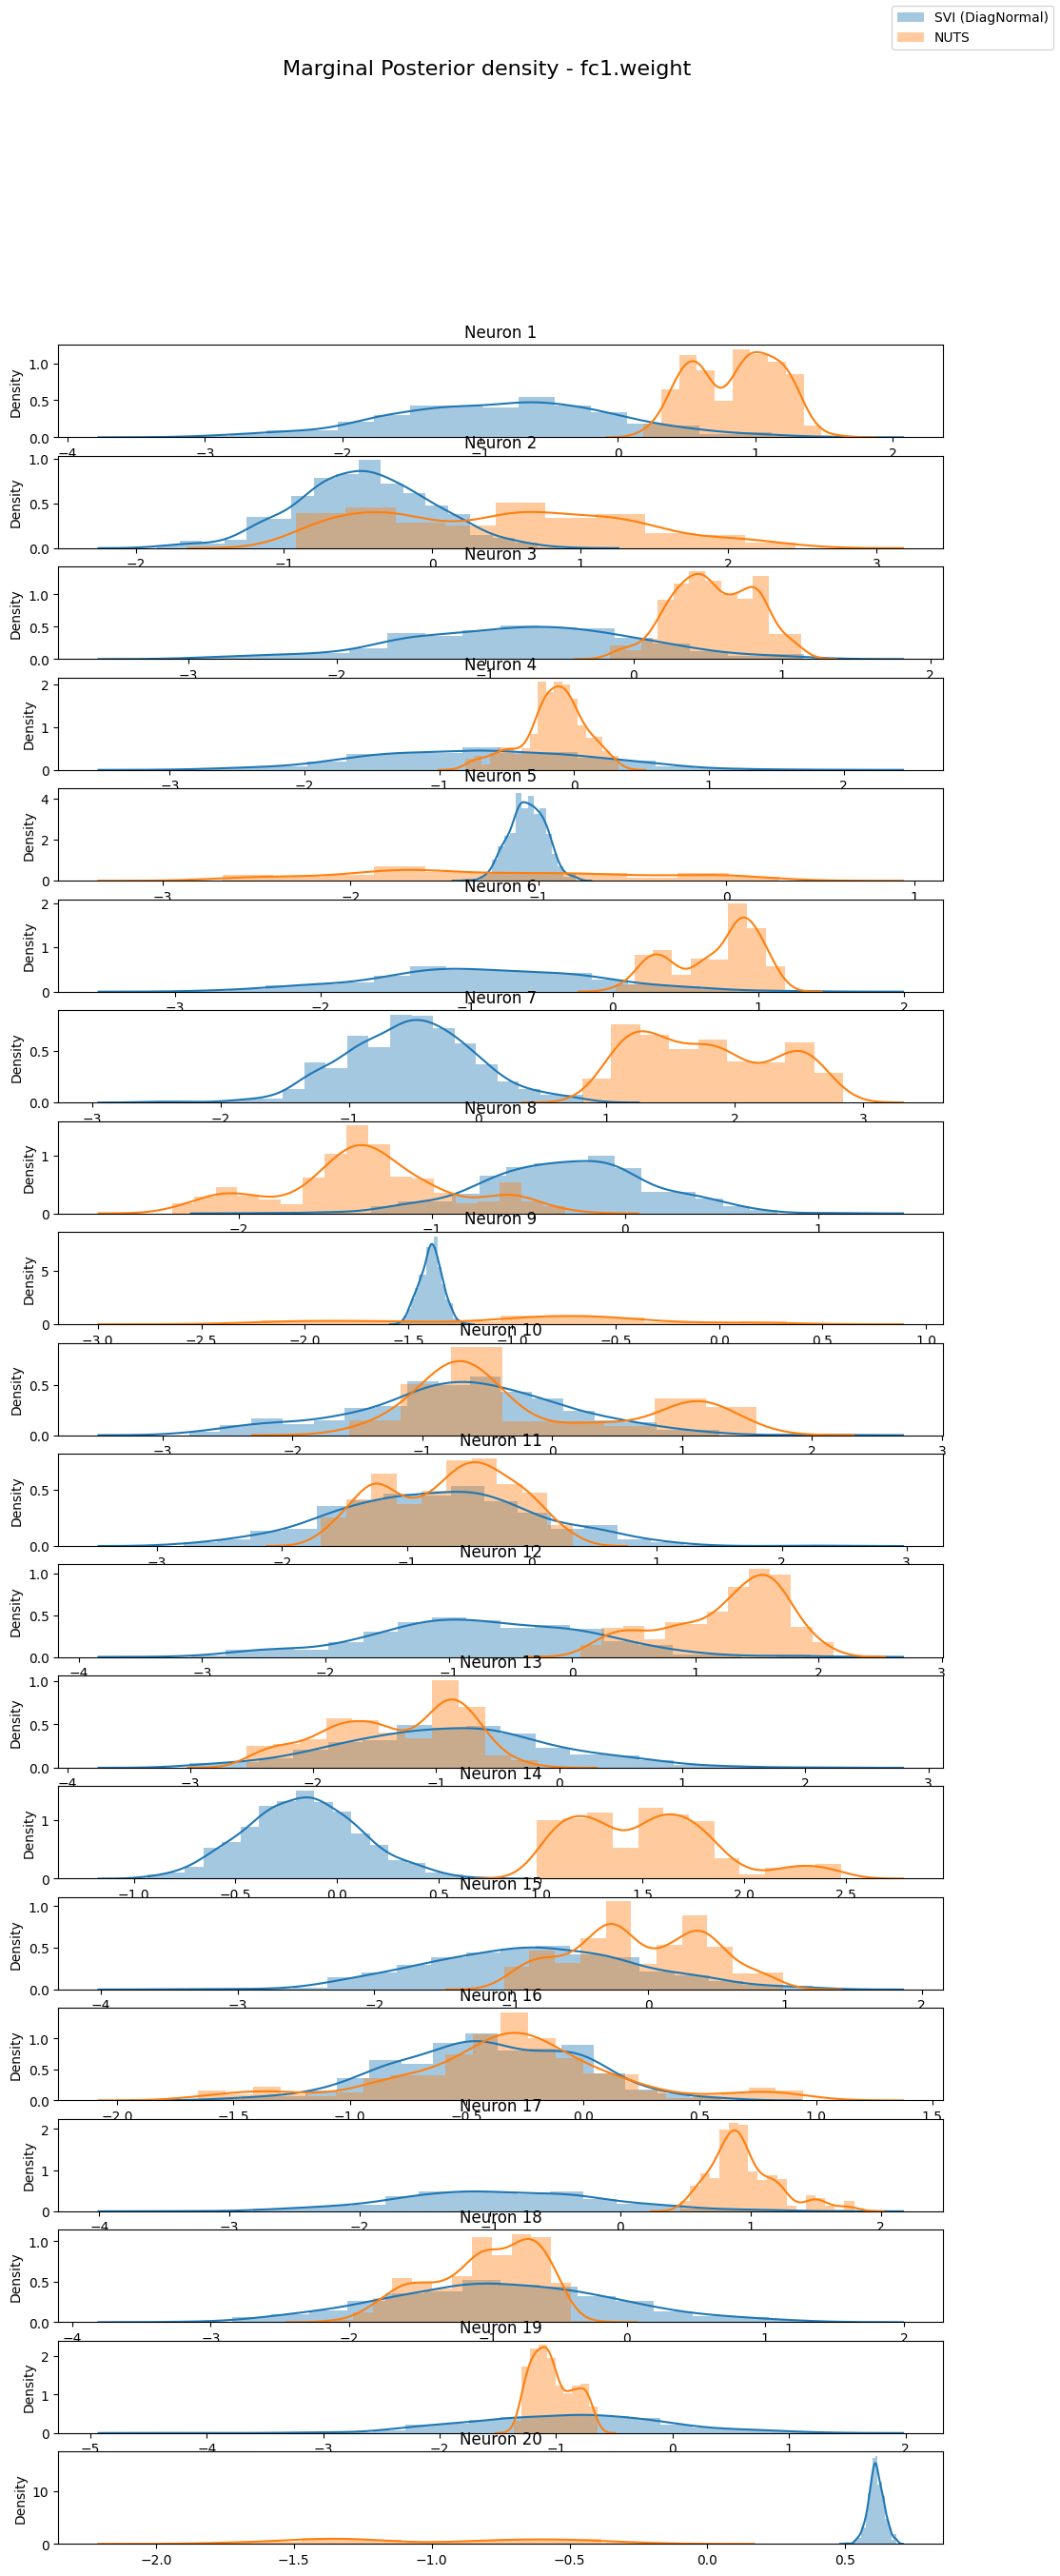

In [54]:
sites = list(svi_samples.keys())
num_neurons = svi_samples[sites[0]].reshape(500,-1).shape[1]
fig, axs = plt.subplots(nrows=num_neurons, figsize=(12, 10*3))
fig.suptitle(f"Marginal Posterior density - {sites[0]}", fontsize=16)

    # If there's only one neuron, make axs a list
if num_neurons == 1:
    axs = [axs]

for i in range(num_neurons):
    neuron_weights_svi = svi_samples[sites[0]].reshape(500,-1)[:, i]
    neuron_weights_nuts = nuts_samples[sites[0]].reshape(500,-1)[:, i]

    sns.distplot(neuron_weights_svi, ax=axs[i], label="SVI (DiagNormal)")
    sns.distplot(neuron_weights_nuts, ax=axs[i], label="NUTS")
    axs[i].set_title(f"Neuron {i+1}")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# 4. Deterministic NN (Point Estimates)

In [56]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10, n_hidden_layers=2, use_dropout=False):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.Tanh()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)
        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean

### Training one NN

In [57]:
def get_simple_data_train():
    x = np.linspace(-.2, 0.2, 500)
    x = np.hstack([x, np.linspace(.6, 1, 500)])
    eps = 0.02 * np.random.randn(x.shape[0])
    y = x + 0.3 * np.sin(2 * np.pi * (x + eps)) + 0.3 * np.sin(4 * np.pi * (x + eps)) + eps
    x_train = torch.from_numpy(x).float()[:, None]
    y_train = torch.from_numpy(y).float()
    return x_train, y_train

def train(net, train_data):
    x_train, y_train = train_data
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    progress_bar = trange(3000)
    for _ in progress_bar:
        optimizer.zero_grad()
        loss = criterion(y_train, net(x_train))
        progress_bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
        loss.backward()
        optimizer.step()
    return net

Retaining the same architecture as that of the BNN, we use a FCN with 2 hidden layers, each with 20 neurons

  0%|          | 0/3000 [00:00<?, ?it/s]

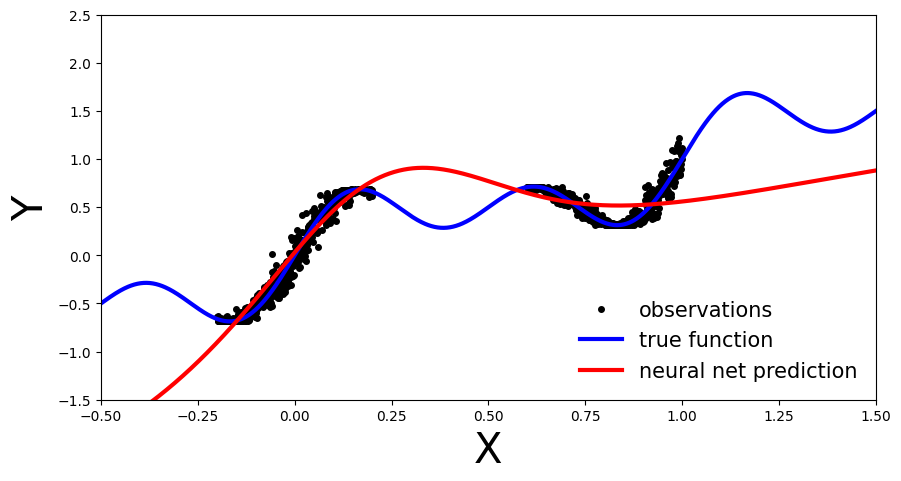

In [81]:
train_data = get_simple_data_train()
x_test = torch.linspace(-.5, 1.5, 3000)[:, None]  # test over the whole range

net_MLP = MLP(hidden_dim=20, n_hidden_layers=2)
net_MLP_train = train(net_MLP, train_data)
y_preds_single_NN = net_MLP_train(x_test).clone().detach().numpy()

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([-.5, 1.5])
plt.ylim([-1.5, 2.5])
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

x_train, y_train = get_simple_data_train()

x_true = np.linspace(-.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

ax.plot(x_train, y_train, 'ko', markersize=4, label="observations")
ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x_test, y_preds_single_NN, 'r-', linewidth=3, label='neural net prediction')

plt.legend(loc=4, fontsize=15, frameon=False)
plt.show()

## 5. Deep Ensemble

In [77]:
ensemble_size = 10
ensemble = [MLP(hidden_dim=20, n_hidden_layers=2) for _ in range(ensemble_size)]
for net in ensemble:
    train(net, train_data)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [78]:
y_preds_ensemble = [np.array(net(x_test[:, None]).clone().detach().numpy()) for net in ensemble]

Plot each ensemble member’s predictive function.

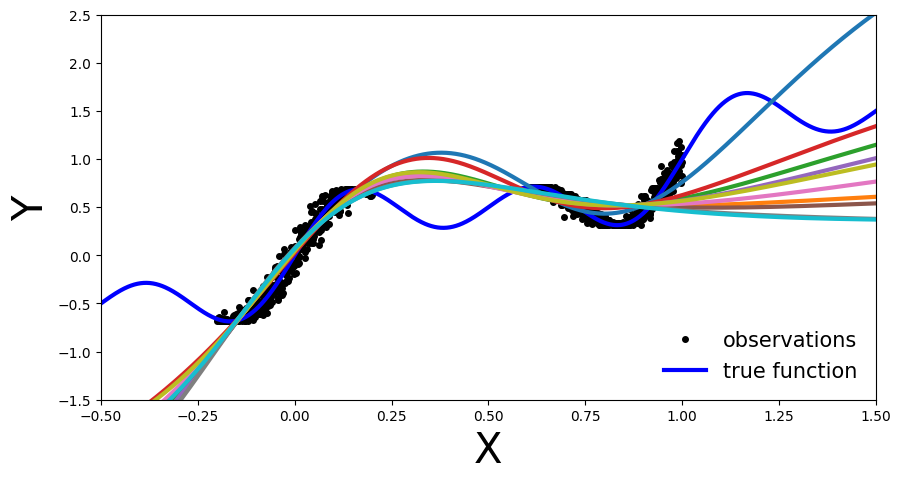

In [79]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlim([-.5, 1.5])
    plt.ylim([-1.5, 2.5])
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    x_train, y_train = get_simple_data_train()

    x_true = np.linspace(-.5, 1.5, 1000)
    y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

    ax.plot(x_train, y_train, 'ko', markersize=4, label="observations")
    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, fontsize=15, frameon=False)
    plt.show()

def plot_multiple_predictions(x_test, y_preds):
    def add_multiple_predictions(ax):
        for idx in range(len(y_preds)):
            ax.plot(x_test, y_preds[idx], '-', linewidth=3)

    plot_generic(add_multiple_predictions)

plot_multiple_predictions(x_test, y_preds_ensemble)


Visualizing the uncertainty bands

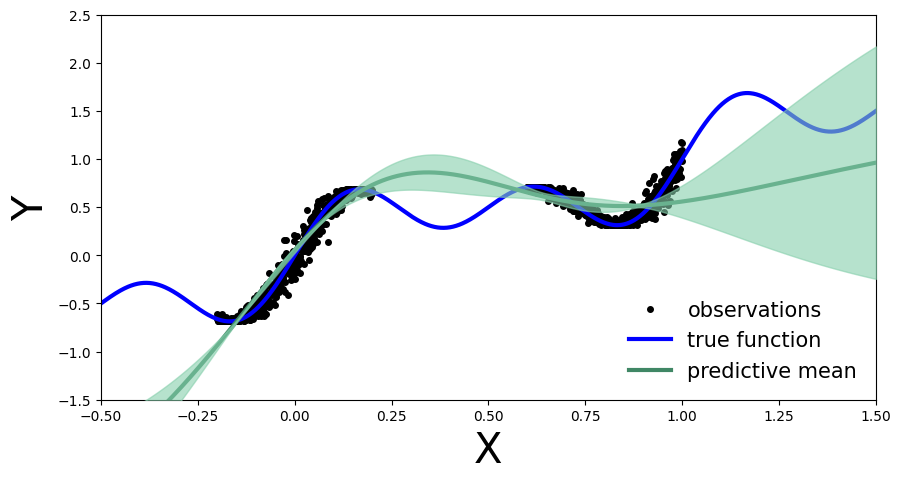

In [80]:
def plot_uncertainty_bands(x_test, y_preds):
    y_preds = np.array(y_preds)
    y_mean = y_preds.mean(axis=0)
    y_std = y_preds.std(axis=0)

    def add_uncertainty(ax):
        ax.plot(x_test, y_mean, '-', linewidth=3, color="#408765", label="predictive mean")
        ax.fill_between(x_test.ravel(), y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plot_generic(add_uncertainty)

plot_uncertainty_bands(x_test, y_preds_ensemble)

strengths and weaknesses (?) of each approach
compare with gpr (?)
prediction uncertainty (interpolation and extrapolation)
predicting outside the range of data
magnitude of noise and its effect on predictive capability
distribution of the weights (?)/ posterior
joint distribution of posterior of weights: hmc vs vi approache maybe (?)
some weights might be deterministic (?), the effect of removing/including these 
put in the basics of the basics of the formulations



## 6. Gaussian Process Regression

GPR with RBF kernel (variance = 0.02, length scale = 0.05) - starting parameters


Name : GP regression
Objective : 976.2354051648001
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |   0.02  |      +ve      |        
  rbf.lengthscale          |   0.05  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


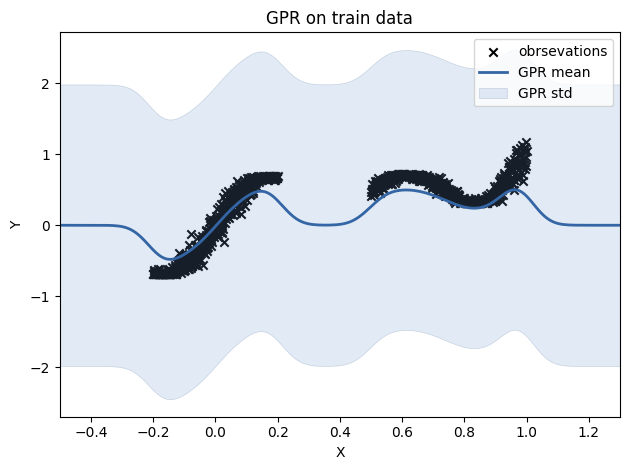

In [57]:
kernel = GPy.kern.RBF(input_dim=1, variance=0.02, lengthscale=0.05) 
m = GPy.models.GPRegression(x_obs.reshape(-1,1),y_obs.reshape(-1,1),kernel)
print(m)
m.plot()
plt.title('GPR on train data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['obrsevations', 'GPR mean', 'GPR std'])

Optimizing GPR hyperparameters (variance and lengthscale)


Name : GP regression
Objective : -1125.913860524442
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |   0.48091788059212526  |      +ve      |        
  rbf.lengthscale          |    0.1877904485630873  |      +ve      |        
  Gaussian_noise.variance  |  0.005733342946187983  |      +ve      |        


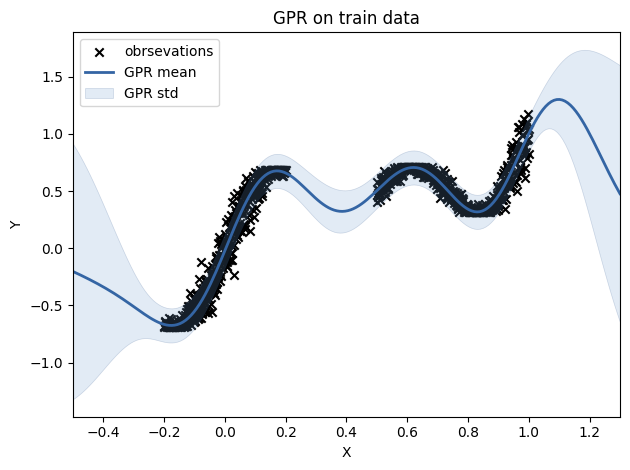

In [60]:
m.unconstrain('rbf.variance')
m.optimize()
print(m)
m.plot()
plt.title('GPR on train data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['obrsevations', 'GPR mean', 'GPR std'])

Plot of predictions on test data (x_test = [-0.5,1.5])

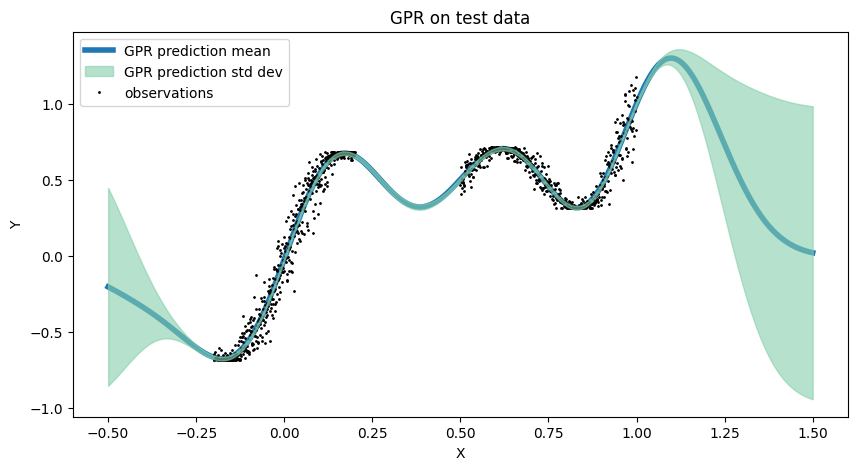

In [56]:
plt.figure(figsize=(10,5))
plt.plot(x_test, m.predict(np.array(x_test.reshape(-1,1)))[0], linewidth=4)
plt.fill_between(x_test.ravel(), m.predict(np.array(x_test.reshape(-1,1)))[0].ravel() - 2 * m.predict(np.array(x_test.reshape(-1,1)))[1].ravel(), m.predict(np.array(x_test.reshape(-1,1)))[0].ravel() + 2 * m.predict(np.array(x_test.reshape(-1,1)))[1].ravel(), alpha=0.6, color='#86cfac', zorder=5)
plt.plot(x_obs, y_obs, 'ko', markersize=1, label="observations")
plt.title('GPR on test data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['GPR prediction mean', 'GPR prediction std dev', 'observations'])
plt.show()